In [ ]:
import requests
import json
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import csv

# Define KServe Inference Service details
INGRESS_HOST = "youtubegoes5g.kubeflow-user-example-com.svc.cluster.local"
INGRESS_PORT = "80"  
SERVICE_HOSTNAME = "youtubegoes5g.kubeflow-user-example-com.svc.cluster.local"
MODEL_NAME = "youtubegoes5g"
REPLICAS = 30
DURATION = 2

# Construct the inference URL and headers
URL = f"http://{INGRESS_HOST}:{INGRESS_PORT}/v1/models/{MODEL_NAME}:predict"
HEADERS = {
    "Host": SERVICE_HOSTNAME,
    "Content-Type": "application/json"
}

# Define the sample data data
# Sample data instances
SAMPLE_DATA = [
    {"data": [13, 13, 13, 0, 13, 13, 13, 13, -76, -76, -81, -76, -78.5, -76, -76, -7, -7, -12, -7, -9.5, -7, -7, 12, 12, 7, 12, 9.5, 12, 12]},
    {"data": [13, 13, 12, 0.4714045208, 13, 12.5, 13, 13, -81, -81, -82, -81, -81.5, -81, -81, -12, -12, -11, -12, -12, -12, -11.5, 7, 7, 2, 7, 4.5, 7, 7]},
    {"data": [14, 12, 11, 1.247219129, 14, 11.5, 12, 13, -82, -76, -76, -76, -79, -76, -76, -11, -7, -7, -7, -9, -7, -7, 2, 9, 9, 9, 5.5, 9, 9]},
    {"data": [13, 13, 7, 2.828427125, 13, 10, 13, 13, -103, -104, -104, -104, -104, -104, -103.5, -6, -12, -12, -12, -12, -12, -9, 14, 16, 16, 16, 15, 16, 16]},
    {"data": [6, 6, 4, 0.9428090416, 6, 5, 6, 6, -103, -102, -102, -102, -102.5, -102, -102, -15, -16, -16, -16, -16, -16, -15.5, -2, -1, -1, -1, -1.5, -1, -1]},
    {"data": [12, 12, 12, 0, 12, 12, 12, 12, -95, -92, -92, -92, -93.5, -92, -92, -11, -13, -13, -13, -13, -13, -12, 8, 9, 9, 9, 8.5, 9, 9]}
]

def getData(numInstances=1):
    """
    Generate inference data with the specified number of data instances.
    
    Args:
        numInstances (int): Number of data instances to include in the request.
                             Defaults to 1.
                             
    Returns:
        dict: JSON data for the inference request.
    """
    # Ensure the number of instances does not exceed available data
    if numInstances > len(SAMPLE_DATA):
        raise ValueError(f"Requested {numInstances} instances, but only {len(SAMPLE_DATA)} are available.")

    # Create the data with the requested number of instances
    return {
        "instances": SAMPLE_DATA[:numInstances]
    }

def request(data):
    return requests.post(URL, headers=HEADERS, data=data)

# Function to handle the inference request
def handleRequest(numInstances=1):
    data = json.dumps(getData(numInstances))
    return request(data)

def experiment(numInstances, requestPeriod, discardFirstN, csvOutputFile, graphOutputFile):
    # Initialize list to store response times
    allResponseTimes = []
    averageTimes = []

    # Outer loop for multiple executions
    for replica in range(REPLICAS):  # Execute 30 times
        replicaResponseTimes = []  # Store response times for this loop
        replicaAverageTime = 0 # Store average response time for this loop
        experimentStartTime = time.time()
        experimentEndTime = experimentStartTime + (DURATION * 60)  # Convert minutes to seconds
        iteration = 0  # Track request number

        while time.time() < experimentEndTime:
            #scheduledTime = experimentStartTime + (iteration * requestPeriod)  # Fixed schedule
            requestTime = time.time()
            response = handleRequest(numInstances)  # Send request
            responseTime = (time.time() - requestTime) * 1000  # Convert to milliseconds
            replicaResponseTimes.append(responseTime)  # Store response time
            #drift = time.time() - scheduledTime  # Clock drift

            if responseTime > requestPeriod:
                print(f"⚠️ Warning: Request took {responseTime:.3f}s, exceeding request period of {requestPeriod:.3f}s.")

            iteration += 1  # Increment iteration count
            nextRequestTime = experimentStartTime + (iteration * requestPeriod)
            
            sleepTime = max(0, nextRequestTime - time.time())  # Adjust for drift
            time.sleep(sleepTime)  # Maintain request frequency

        # Check if the actual number of iterations matches the expected number
        expectedIterations = int((DURATION * 60) / requestPeriod)

        if iteration < expectedIterations:
            print(f"⚠️ Alert: Expected {expectedIterations} iterations but only completed {iteration}.")
            print("🔄 Consider increasing `requestPeriod` to ensure all requests complete within the expected time.")
        # else:
        #     print("✅ Experiment completed successfully with the expected number of iterations.")

            
        # Discard the first `n` response times
        filteredResponseTimes = replicaResponseTimes[discardFirstN:]

        # Calculate the average response time for this run
        #totalTime = sum(filteredResponseTimes)
        replicaAverageTime = sum(filteredResponseTimes) / len(filteredResponseTimes)
        averageTimes.append(replicaAverageTime)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

        # Append this loop's times to the main list
        allResponseTimes.append(replicaResponseTimes)

        #print(f"Loop {outer_loop + 1} completed in {experimentEndTime - requestTime:.2f} seconds.")
        
        # Wait some time before the next replica
        time.sleep(requestPeriod*2)

    with open(csvOutputFile, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(replicaResponseTimes))] + ["Average"])
        for replica in range(REPLICAS):
            writer.writerow([replica+1] + allResponseTimes[replica] + [averageTimes[replica]])

    #print("Response times saved to 'replicaResponseTimes.csv'.")

    # Plot the averages from all runs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, REPLICAS + 1), averageTimes, marker='o', label="Average Response Time (ms)")
    plt.xlabel("Run Number")
    plt.ylabel("Average Response Time (ms)")
    plt.title("Average Response Times Across Multiple Runs")
    plt.xticks(range(1, REPLICAS + 1))
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Save the plot as an image
    plt.savefig(graphOutputFile, format="png", dpi=300)  # Save with high resolution
    #print(f"Plot saved as '{output_file}'.")

    # Optionally show the plot
    plt.show()

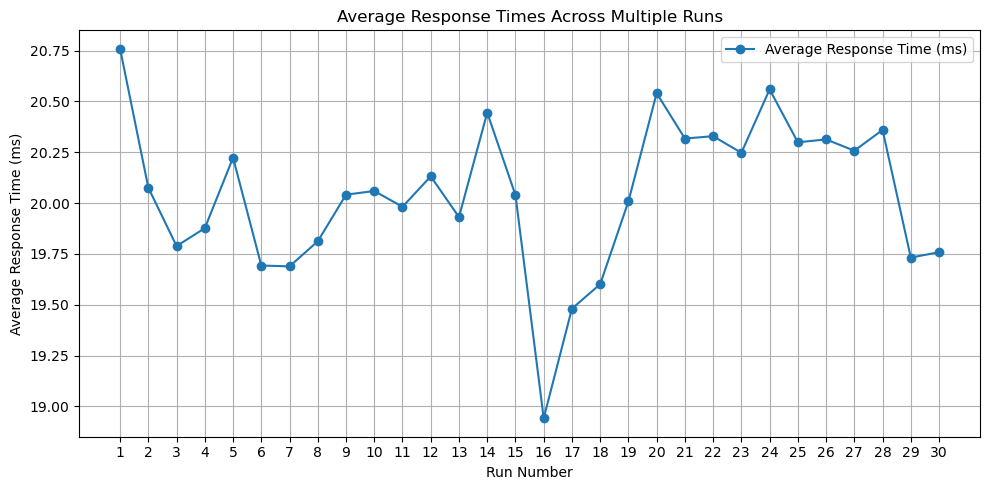

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
numInstances = 1
csv_file = "test1_P2_I1.csv"  # Output CSV file
graph_file = "test1_P2_I1.png"

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")          # Wait some time before the next replica     time.sleep(n_seconds*2)
    
    # Wait some time before the next replica
    time.sleep(n_seconds*2)
    

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

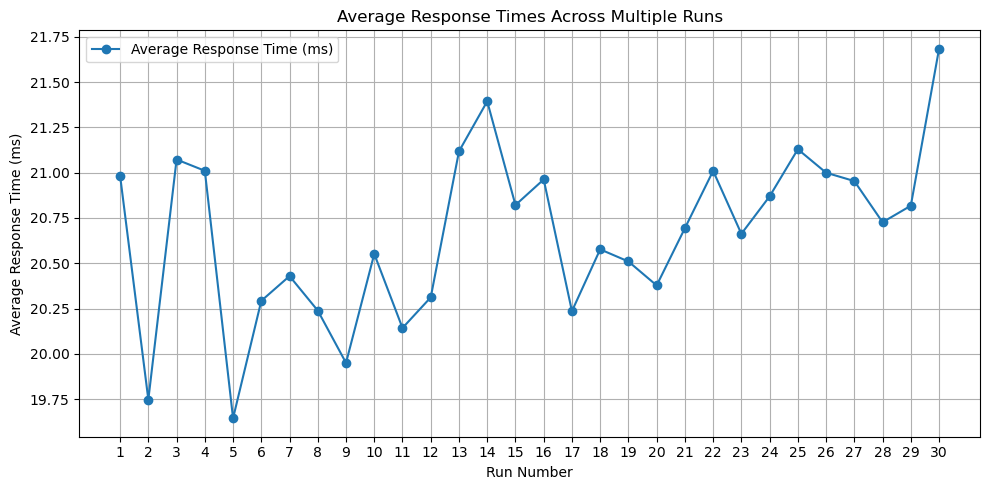

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
numInstances = 1
csv_file = "test2_P3_I1.csv"  # Output CSV file
graph_file = "test2_P3_I1.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")          
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

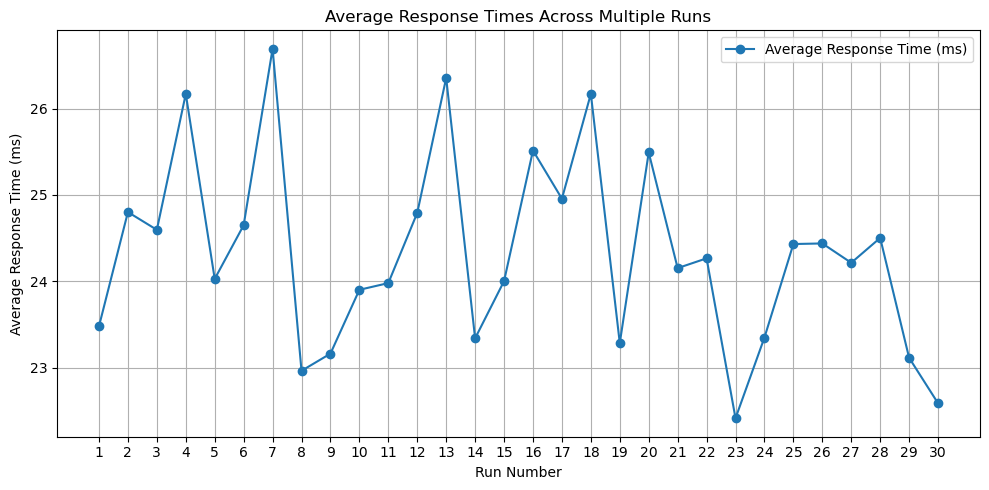

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
numInstances = 1
csv_file = "test3_P12_I1.csv"  # Output CSV file
graph_file = "test3_P12_I1.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.") 
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

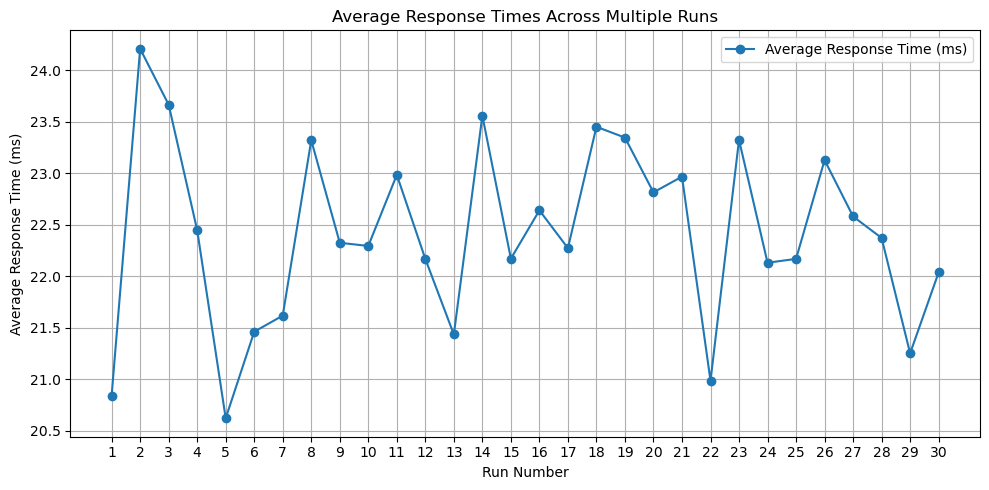

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
numInstances = 4
csv_file = "test4_P2_I4.csv"  # Output CSV file
graph_file = "test4_P2_I4.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")  
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

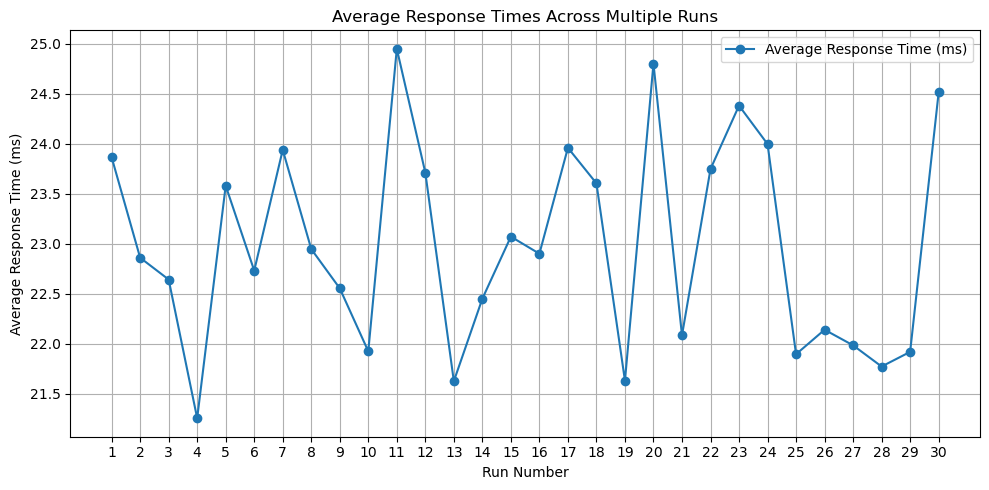

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
numInstances = 4
csv_file = "test5_P3_I4.csv"  # Output CSV file
graph_file = "test5_P3_I4.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")   
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'loop_response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

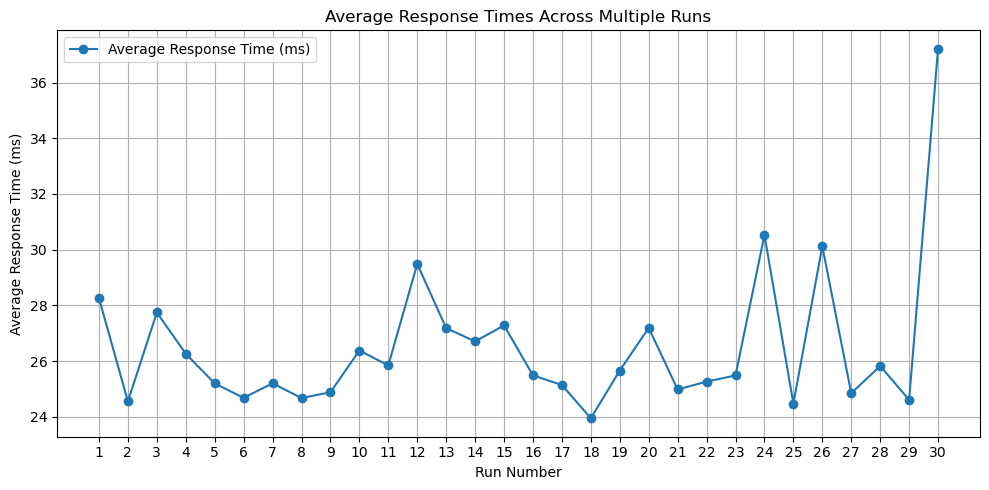

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
numInstances = 4
csv_file = "test6_P12_I4.csv"  # Output CSV file
graph_file = "test6_P12_I4.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

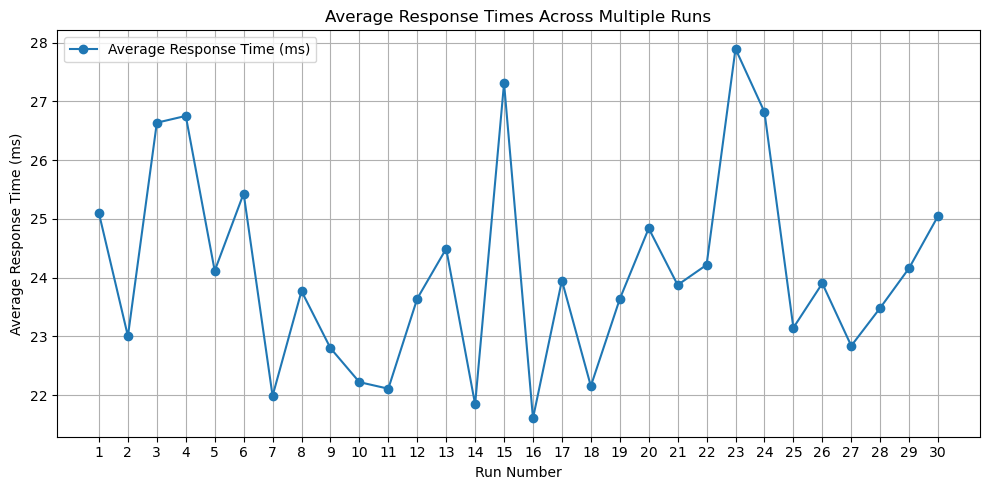

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 2  # Interval in seconds between requests
discard_first_n = 12  # Number of values to discard
numInstances = 6
csv_file = "test7_P2_I6.csv"  # Output CSV file
graph_file = "test7_P2_I6.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")  
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

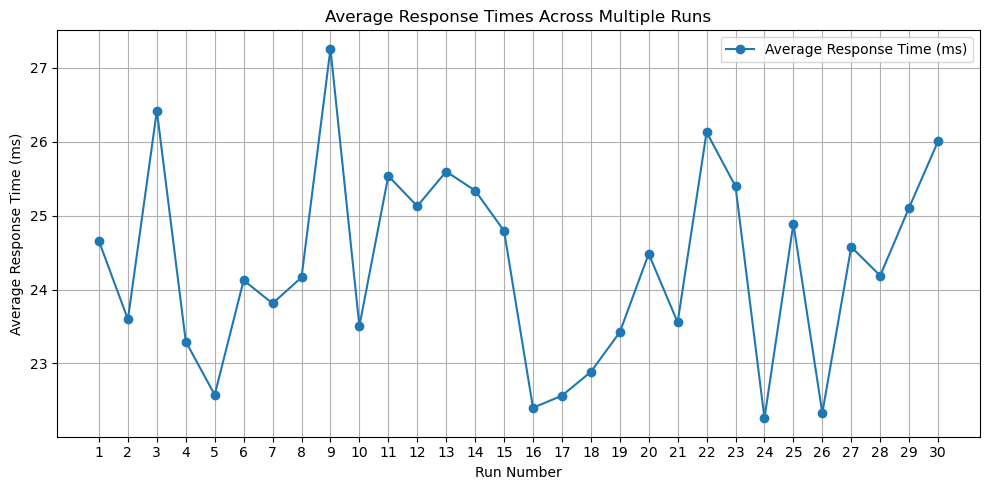

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 3  # Interval in seconds between requests
discard_first_n = 8  # Number of values to discard
numInstances = 6
csv_file = "test8_P3_I6.csv"  # Output CSV file
graph_file = "test8_P3_I6.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.")   
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)

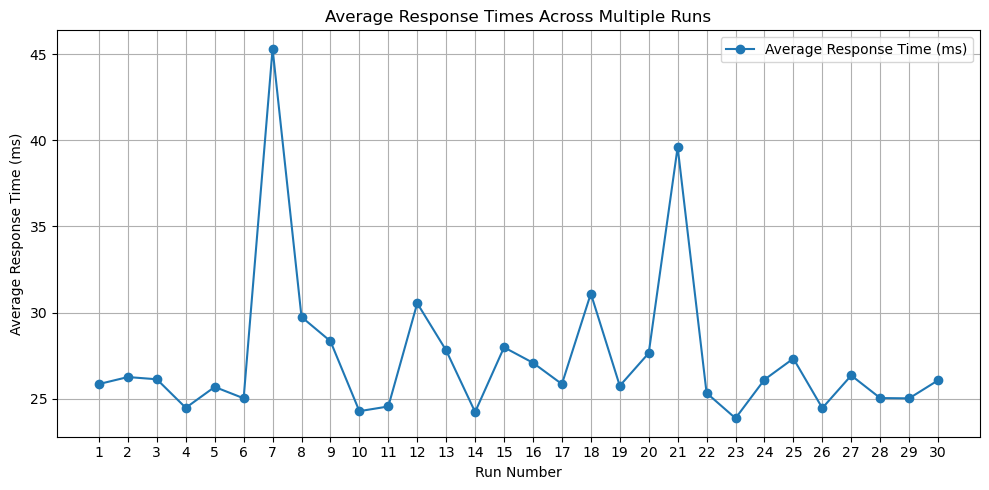

In [ ]:
# Configuration: Interval, Duration, and Runs
n_seconds = 12  # Interval in seconds between requests
discard_first_n = 2  # Number of values to discard
numInstances = 6
csv_file = "test9_P12_I6.csv"  # Output CSV file
graph_file = "test9_P12_I6.png"

# Give some time before the next tests
time.sleep(n_seconds*2)

# Initialize list to store response times
all_response_times = []
average_times = []

# Outer loop for multiple executions
for replica in range(1, REPLICAS + 1):  # Execute 30 times
    loop_response_times = []  # Store response times for this loop
    loop_average = 0 # Store average response time for this loop
    
    # Calculate the end time for this run
    end_time = datetime.now() + timedelta(minutes=DURATION)

    # Inner loop to send requests every n seconds until the duration ends
    while datetime.now() < end_time:
        start_time = time.time()
        result = handleRequest(numInstances)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        loop_response_times.append(elapsed_time)  # Store response time
        #print(f"Response: {result}")
        #print(f"Response Time: {elapsed_time:.2f} ms")
        #print("-----------------------------------------")
        time.sleep(n_seconds)
        
    # Discard the first `n` response times
    if len(loop_response_times) > discard_first_n:
        filtered_response_times = loop_response_times[discard_first_n:]
    else:
        filtered_response_times = loop_response_times  # Not enough data to discard

    # Calculate the average response time for this run
    if filtered_response_times:
        total_time = sum(filtered_response_times)
        loop_average = total_time / len(filtered_response_times)
        average_times.append(loop_average)
        #print(f"Run {run}: Average Response Time = {average_time:.2f} ms")

    # Append this loop's times to the main list
    all_response_times.append(loop_response_times)

    #print(f"Loop {outer_loop + 1} completed in {end_time - start_time:.2f} seconds.") 
    
    # Wait some time before the next replica     
    time.sleep(n_seconds*2)

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Replica"] + [f"Request {i+1}" for i in range(len(loop_response_times))] + ["Average"])
    for replica in range(1, REPLICAS + 1):
        writer.writerow([replica] + all_response_times[replica-1] + [average_times[replica-1]])

#print("Response times saved to 'response_times.csv'.")

# Plot the averages from all runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, REPLICAS + 1), average_times, marker='o', label="Average Response Time (ms)")
plt.xlabel("Run Number")
plt.ylabel("Average Response Time (ms)")
plt.title("Average Response Times Across Multiple Runs")
plt.xticks(range(1, REPLICAS + 1))
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot as an image
plt.savefig(graph_file, format="png", dpi=300)  # Save with high resolution
#print(f"Plot saved as '{output_file}'.")

# Optionally show the plot
plt.show()

# Give some time before the next tests
time.sleep(n_seconds*2)